# ZTF Summer School 2025 - Day 3

## Building a Deep Learning Model: A Case Study in Spectral Classification

In this notebook, we will take a look at the process of how to build and train a model for spectral classification.  
The same methodology can also be applied to other tasks involving convolutional networks (CNNs).

---

### We will follow these steps:

1. Download and Prepare the Dataset  
2. Understand the Dataset Structure and Meaning
3. Know the Components of a Deep Learning Model
4. Build a Model
5. Train the Model on the Data  
6. Analyze and Understand the Results

In [10]:
# pip install -r requirements.txt

###  Dataset Preparation

The dataset has been preprocessed and split into three subsets:

- `train.pt`: training set containing 560 samples per class
- `val.pt`: validation set containing 120 samples per class
- `test.pt`: test set containing 120 samples per class

Each `.pt` file is a PyTorch-saved dictionary with the following structure:

- `flux`: Tensor of shape `(N, 1, 4096)`, representing normalized and interpolated spectral flux data
- `labels`: List of integer class labels corresponding to each spectrum

These files are ready to be directly loaded into PyTorch `Dataset` and `DataLoader` classes for training, validation, and evaluation.


## Download the data
Link:https://drive.google.com/drive/folders/1nQP6WPMmfGSIQzhK7soLeSWMw2-7tHK9?usp=drive_link

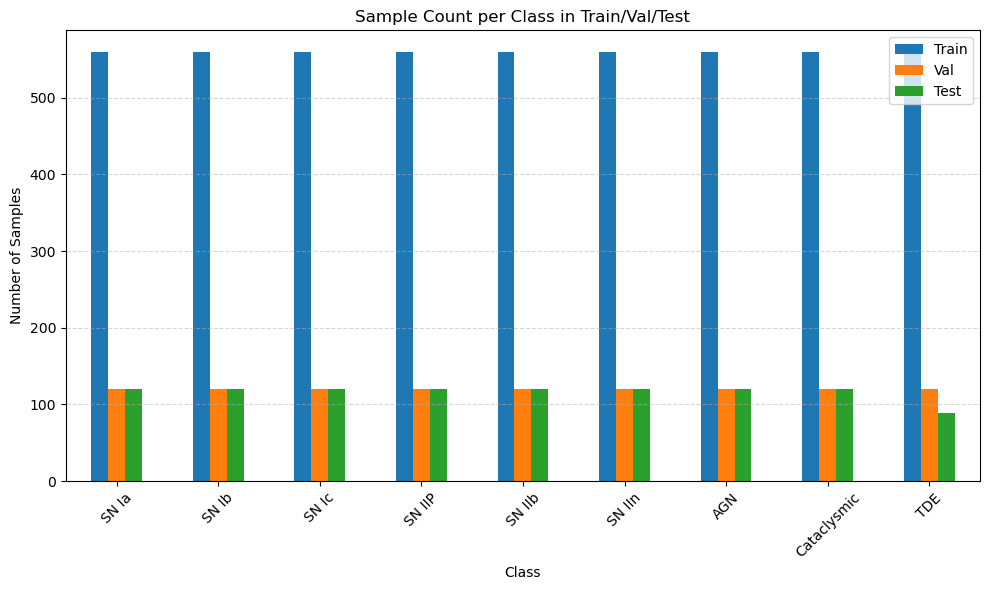

,Train,Val,Test
SN Ia,560,120,120
SN Ib,560,120,120
SN Ic,560,120,120
SN IIP,560,120,120
SN IIb,560,120,120
SN IIn,560,120,120
AGN,560,120,120
Cataclysmic,560,120,120
TDE,560,120,89


In [2]:
from utils import *
from exercise import *
class_order = ['SN Ia', 'SN Ib', 'SN Ic', 'SN IIP', 'SN IIb', 'SN IIn', 'AGN', 'Cataclysmic', 'TDE']
plot_label_distribution_from_pt(pt_dir="Data", class_order=class_order)

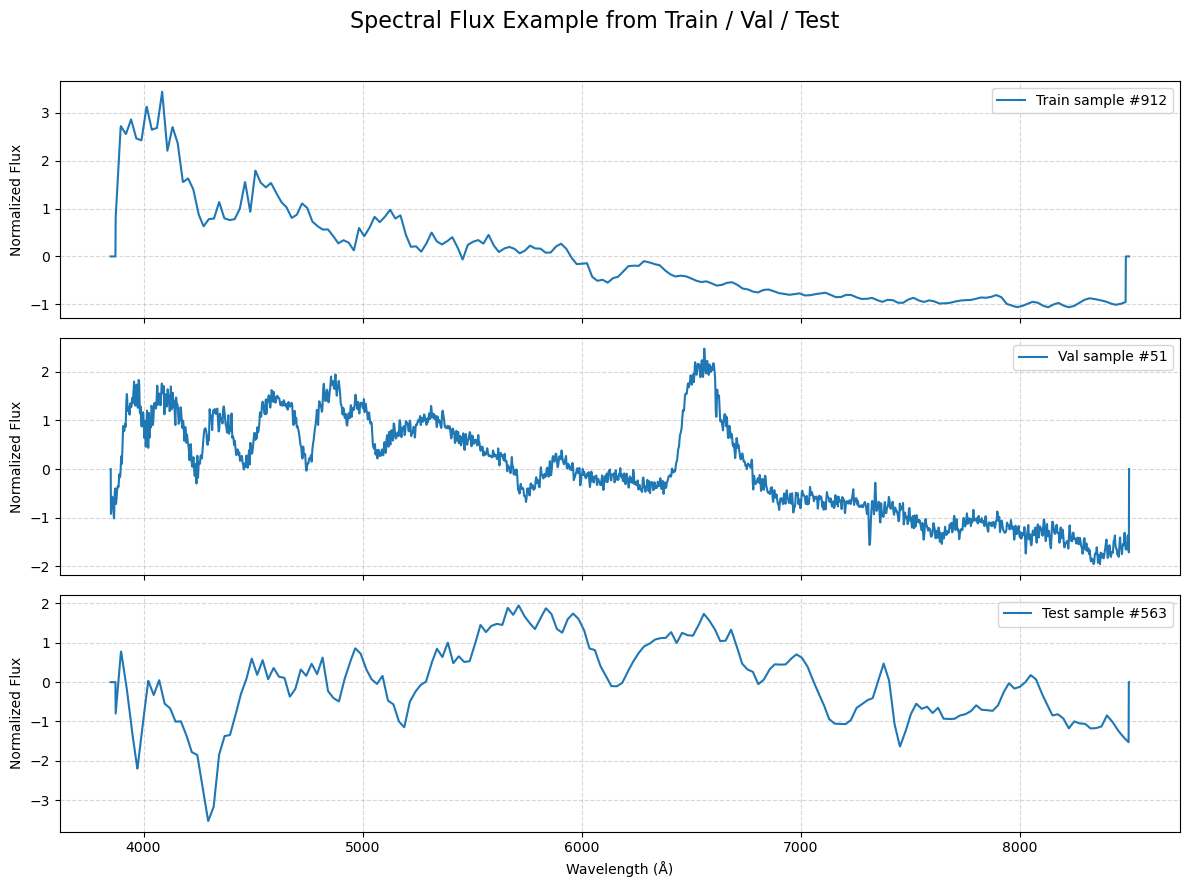

In [3]:
plot_flux_examples_three_panels(
    pt_dir="Data",
    wavelength_range=(3850, 8500),
    interp_len=4096
)

###  Dataset and Dataloader Explanation

The code below defines how we load the spectral data stored in `.pt` format using PyTorch's `Dataset` and `DataLoader` classes.

####  `SpectraPTDataset`

This custom dataset class does the following:

- Loads a `.pt` file containing:
  - `flux`: a tensor of shape `(N, 1, 4096)` for each interpolated spectrum
  - `labels`: a list of class labels (either strings or integers)
- Optionally maps string labels to class indices using `class_order`
- Returns each sample as `(x, y)`:
  - `x`: normalized flux tensor of shape `(1, 4096)`
  - `y`: integer class label

####  `create_data_loaders(config)`

This utility function:

- Creates `train`, `val`, and `test` datasets using `SpectraPTDataset`
- Wraps them with PyTorch `DataLoader`s
  - `shuffle=True` for training
  - `shuffle=False` for validation and test
- Returns the three loaders and the class index order

> These loaders will be used during model training, validation, and evaluation.

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch

class SpectraPTDataset(Dataset):
    def __init__(self, pt_path, label_key='labels', class_order=None):
        data = torch.load(pt_path)
        self.flux = data['flux']
        self.labels = data[label_key]

        assert self.flux.shape[0] == len(self.labels), "Mismatch in flux and redshift length"

        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(class_order)} if class_order else None

        if self.class_to_idx and isinstance(self.labels[0], str):
            self.labels = [self.class_to_idx[label] for label in self.labels]

    def __len__(self):
        return self.flux.shape[0]

    def __getitem__(self, idx):
        x = self.flux[idx]
        if x.dim() == 1:
            x = x.unsqueeze(0)  # [1, 4096]
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y
    
    
def create_data_loaders(config):
    class_order = config['class_order'] 

    train_dataset = SpectraPTDataset(
        pt_path=config['train_dir'],
        label_key='labels',
        class_order=class_order
    )
    val_dataset = SpectraPTDataset(
        pt_path=config['val_dir'],
        label_key='labels',
        class_order=class_order
    )
    test_dataset = SpectraPTDataset(
        pt_path=config['test_dir'],
        label_key='labels',
        class_order=class_order
    )

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'])
    val_loader   = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'])
    test_loader  = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'])

    return train_loader, val_loader, test_loader, class_order

###  Training and Validation Loop Explanation

We define two core functions to handle model training and evaluation:

---

####  `train_one_epoch(model, loader, criterion, optimizer, device, scaler, max_grad_norm)`

This function performs a **single training epoch**:

- **Set model to training mode**: `model.train()`
- **Loop over mini-batches** from `loader`:
  - Move `sequence` and `target` to GPU/CPU
  - Use **mixed precision** with `torch.amp.autocast` for faster training
  - Compute predictions and loss
  - Backpropagate using `scaler.scale(loss).backward()`
  - Clip gradients to prevent exploding gradients
  - Update model parameters and scaler
- Tracks running average of:
  - `loss`
  - `accuracy` (top-1)

 **Returns**: average loss and accuracy of the epoch

---

####  `validate(model, loader, criterion, device, class_names, epoch_type="val")`

This function evaluates the model on **validation or test set**:

- Set model to evaluation mode: `model.eval()`
- Disable gradients: `torch.no_grad()`
- Loop over batches and:
  - Compute predictions and loss
  - Use `torch.softmax` to get class probabilities
  - Compute:
    - Top-1 Accuracy
    - Top-3 Accuracy
    - Macro F1 Score
- Optionally plots confusion matrix for test set

 **Returns**: `loss`, `top-1 accuracy`, and `macro F1 score`

In [8]:

def train_one_epoch(model, loader, criterion, optimizer, device, scaler, max_grad_norm=1.0):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    progress_bar = tqdm(loader, desc="Training")

    for sequence, target in progress_bar:
        sequence, target = sequence.to(device), target.to(device)
        optimizer.zero_grad()

        with autocast(device_type='cuda', enabled=torch.cuda.is_available()):
            outputs = model(sequence)
            loss = criterion(outputs, target)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += preds.eq(target).sum().item()
        total += target.size(0)
        progress_bar.set_postfix(loss=loss.item(), acc=100. * correct / total)

    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device, class_names, epoch_type="val"):
    model.eval()
    total, correct, correct_top3, running_loss = 0, 0, 0, 0.0
    all_preds, all_targets = [], []
    progress_bar = tqdm(loader, desc="Validation")

    with torch.no_grad():
        for sequence, target in progress_bar:
            sequence, target = sequence.to(device), target.to(device)

            with autocast(device_type='cuda', enabled=torch.cuda.is_available()):
                output = model(sequence)
                loss = criterion(output, target)
                probs = torch.softmax(output, dim=1)

            preds = output.argmax(dim=1)
            correct += preds.eq(target).sum().item()
            _, top3 = output.topk(3, dim=1)
            correct_top3 += (top3 == target.view(-1, 1)).any(dim=1).sum().item()
            total += target.size(0)
            running_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            progress_bar.set_postfix(loss=loss.item(), acc=100. * correct / total)

    val_loss = running_loss / len(loader)
    val_acc = 100. * correct / total
    val_f1 = f1_score(all_targets, all_preds, average='macro') 
    #he uses macro fro class imbalence (which it's barely imbalenced)
    #you can use micro for balenced classes

    if epoch_type == "test":
        plot_confusion_matrix_double(all_targets, all_preds, class_names, dataset_type="Test")

    return val_loss, val_acc, val_f1


##### Common Loss Functions

This note covers the most commonly used loss functions in classification and regression tasks.

---

### 1. Classification Losses

####  Binary Cross Entropy (BCE)

- **Use case**: Binary classification (e.g., 0 vs 1)
- **Prediction format**: Output should be a probability in [0, 1] (use Sigmoid)
- **PyTorch**:
  - `nn.BCELoss()` — requires manual `Sigmoid`
  - `nn.BCEWithLogitsLoss()` — includes `Sigmoid` internally (recommended)

---

####  Cross Entropy Loss

- **Use case**: Multi-class classification
- **Prediction format**:
  - Targets: class indices (e.g., 0, 1, 2, ...)
  - Predictions: raw logits (no `Softmax` needed)
  where \( C \) is the number of classes.
- **PyTorch**: `nn.CrossEntropyLoss()` (automatically applies `LogSoftmax`)

---

### 2. Regression Losses

####  Mean Squared Error (MSE)

- **Use case**: General regression tasks
- **Properties**: Sensitive to outliers; penalizes large errors more
- **PyTorch**: `nn.MSELoss()`

---

####  Mean Absolute Error (MAE)

- **Use case**: Regression with outliers

- **Properties**: More robust to outliers; less sensitive to large errors
- **PyTorch**: `nn.L1Loss()`

---

###  Summary Table

| Task          | Loss Function     | Description                            | PyTorch API            |
|---------------|-------------------|----------------------------------------|-------------------------|
| Classification | Binary Cross Entropy | For binary classification             | `nn.BCEWithLogitsLoss()` |
| Classification | Cross Entropy       | For multi-class classification        | `nn.CrossEntropyLoss()`   |
| Regression     | Mean Squared Error  | Penalizes large errors (sensitive)    | `nn.MSELoss()`            |
| Regression     | Mean Absolute Error | Robust to outliers                    | `nn.L1Loss()`             |


###  Optimizer vs Scheduler

<img src="assets/Optimizer.png" alt="Optimizer" width="400">

- **Optimizer**: Updates model weights using gradient from loss.
- **Scheduler**: Dynamically adjusts learning rate used by the optimizer.

---

###  Training Step Flow

```python
# Forward pass
outputs = model(inputs)
loss = loss_fn(outputs, targets)   # ← 1. Compute loss

# Backward pass
loss.backward()                    # ← 2. Compute gradients

# Optimizer step
optimizer.step()                   # ← 3. Update parameters using gradients

# Learning rate scheduler step
scheduler.step()                   # ← 4. Adjust learning rate for next step
```

### Analogy Table: Understanding the Training Components

| Concept      | Real-World Role       | Responsibility                        | Analogy Explanation |
|--------------|------------------------|----------------------------------------|----------------------|
| **Loss**     | Map / Destination      | Measures how far off the model is     | Like a GPS showing how far you are from your target |
| **Gradient** | Navigation Directions  | Tells the direction to adjust weights | Like GPS arrows telling you which way to turn |
| **Optimizer**| Driver / Steering Wheel| Updates model parameters               | The driver turning the wheel to follow the path |
| **Scheduler**| Gas Pedal Controller   | Adjusts learning rate (speed)          | Controls how fast the car moves—slow at start (warmup), then speeds up, then slows down again (decay) |



###  Common Optimizers: SGD, SGD + Momentum, Adam, AdamW

| Optimizer         | Momentum | Adaptive LR | Description                                        | Pros                                         | Cons                                      | Typical Use Cases                        |
|-------------------|----------|-------------|----------------------------------------------------|----------------------------------------------|-------------------------------------------|-------------------------------------------|
| **SGD**           | ❌        | ❌           | Basic stochastic gradient descent                  | Very simple, transparent behavior             | Converges slowly, easily trapped in minima | Very small models, baseline comparison     |
| **SGD + Momentum**|  ✅       | ❌           | Adds velocity to SGD to smooth and accelerate updates | Strong generalization, CV standard choice     | Sensitive to learning rate and momentum     | Large-scale CNNs (ResNet, EfficientNet), image classification |
| **Adam**          |  ✅       |    ✅        | Combines momentum and per-parameter adaptive LR    | Fast convergence, easy to use                 | May overfit, slightly worse generalization  | NLP, small data, fast prototyping          |
| **AdamW**         |    ✅     |    ✅        | Adam with decoupled weight decay for better regularization | Fast + stable, strong for modern deep nets    | Slightly higher memory usage                | Transformers, ViT, large CNNs              |


Common Learning Schedule 

<img src="assets/LR_Schedule.png" alt="LR-Schedule" width="800">

| Scheduler                    | Mechanism                                 | Key Parameters                                           | LR Trend                       | Cyclic | Recommended Scenarios                             |
|-----------------------------|-------------------------------------------|----------------------------------------------------------|--------------------------------|--------|---------------------------------------------------|
| **Constant LR**             | Keep learning rate constant               | `lr`                                                     | Constant                       | ❌     | Simple models, debugging                         |
| **StepLR**                  | Decay LR every fixed number of epochs     | `step_size`, `gamma`                                     | Step-wise decay               | ❌     | Classic CNNs like ResNet, VGG                   |
| **MultiStepLR**             | Decay LR at specified epochs              | `milestones`, `gamma`                                    | Multi-step decay              | ❌     | Fine-tuning with empirical control              |
| **ExponentialLR**           | Multiply LR by γ every epoch              | `gamma`                                                  | Exponential decay             | ❌     | Small models or fast convergence                |
| **CosineAnnealingLR**       | Cosine decay to minimum                   | `T_max`, `eta_min`                                       | One-shot cosine decay         | ❌     | Transformers, vision models                     |
| **CosineAnnealingWarmRestarts** | Multiple cosine decays with restarts         | `T_0`, `T_mult`, `eta_min`                               | Cosine waves with restarts    |  ✅    | Pretraining large models, escaping local minima |
| **CyclicLR**                | Oscillate between `base_lr` and `max_lr`  | `base_lr`, `max_lr`, `step_size_up`, `mode`              | Cyclic up and down            |   ✅   | NLP, large-scale training, saddle point escape  |
| **OneCycleLR**              | Increase then sharply decrease LR         | `max_lr`, `steps_per_epoch`, `epochs`, `pct_start`       | One-shot triangular schedule  | ❌     | Modern DNNs, transfer learning, fine-tuning     |


###  Main Training Function Explained (`main()`)

The `main()` function manages the full pipeline from training to evaluation. It consists of several key stages:

---

#### 1. Initialization

- `torch.cuda.synchronize()` ensures CUDA is ready before training.
- `set_seed()` ensures reproducibility across runs.
- `get_device()` detects whether to use GPU or CPU.
- `print_config()` logs current hyperparameter settings.

---

#### 2. Data Loading

- `create_data_loaders(config)` loads `.pt` files for training, validation, and testing.
- Returns `train_loader`, `val_loader`, `test_loader`, and `class_names` (label order).

---

#### 3. Model, Optimizer, Scheduler Setup

- `build_model(config)` builds a model.
- `build_optimizer()` sets up AdamW optimizer with given learning rate and weight decay.
- `build_scheduler()` sets up a learning rate scheduler (warmup + cosine annealing).

---

#### 4. Class-Balanced Loss & Mixed Precision Setup

- `FocalLoss` is used to handle class imbalance, with weights computed from `train_labels`.
- If labels are strings, they're mapped to integer indices using `class_names`.
- `torch.amp.GradScaler()` enables automatic mixed precision for faster training.

---

#### 5. Training Loop

For each epoch:
- Call `train_one_epoch()`:
  - Performs forward + backward pass, gradient clipping, optimizer step
  - Tracks average loss and top-1 accuracy
- Call `validate()` on validation set:
  - Computes validation loss, accuracy, macro F1
- If validation F1 improves:
  - Save the best model checkpoint (`best_model.pth`)
  - Reset `no_improve_epochs` counter
- If not:
  - Increment `no_improve_epochs`
- If early stopping triggered:
  - Stop training early to prevent overfitting

---

#### 6. Final Testing

- If mode is `'train'`, the best checkpoint is reloaded.
- `validate()` is called on the test set.
- Final test loss, accuracy, and F1 score are printed and returned.

---

####  Final Output

Returns:
- Best test F1 score (for logging or hyperparameter tuning)
- A dictionary of test metrics: `f1`, `acc`, `loss`

In [44]:

def main(trial=None, config=None, mode='train', build_model_fn=None):
    import torch.nn as nn

    #torch.cuda.synchronize()
    set_seed(config.get('seed', 42))
    print_config(config, trial)
    device = get_device()

    # Data loaders
    train_loader, val_loader, test_loader, class_names = create_data_loaders(config)

    # Build model
    model =  build_model(config).to(device)

    # optimizer 
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )

    #scheduler
    warmup_epochs = config.get('warmup_epochs', 5)
    warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=config['start_factor'],
        end_factor=config['end_factor'],
        total_iters=warmup_epochs
    )
    cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=config['T_0'],
        T_mult=config['T_mult'],
        eta_min=config['eta_min']
    )
    scheduler = torch.optim.lr_scheduler.SequentialLR(
        optimizer,
        schedulers=[warmup_scheduler, cosine_scheduler],
        milestones=[warmup_epochs]
    )


    criterion = nn.CrossEntropyLoss()
    scaler = torch.amp.GradScaler()

    best_val_f1 = 0.0
    no_improve_epochs = 0
    save_dir = config.get("model_save_dir", "../checkpoints")
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(config['epochs']):
        print(f"\n[Epoch {epoch+1}/{config['epochs']}]")

        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, scaler,
            max_grad_norm=1.0  
        )

        val_loss, val_acc, val_f1 = validate(
            model, val_loader, criterion, device, class_names, epoch_type="val"
        )

        print(f"📊 [Val @ Epoch {epoch+1}] Acc: {val_acc:.2f}%, F1: {val_f1:.4f}")
        scheduler.step()

        if val_f1 > best_val_f1 + 1e-6:
            best_val_f1 = val_f1
            no_improve_epochs = 0
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
            print(f">>> 🚀🚀🚀 New Best F1: {best_val_f1:.4f}")
        else:
            no_improve_epochs += 1
            print(f">>> No F1 improvement for {no_improve_epochs} epoch(s)")

        if early_stopping(no_improve_epochs, config['patience']):
            print(">>> Early stopping triggered.")
            break

        clean_memory()

    print(f"\n Best F1 on Validation: {best_val_f1:.4f}")

    # Directly evaluate on test set
    print("\n>>> Final Testing on Test Set...")
    model.load_state_dict(torch.load(os.path.join(save_dir, "best_model.pth")))
    model.eval()

    test_loss, test_acc, test_f1 = validate(
        model, test_loader, criterion, device, class_names, epoch_type="test"
    )

    print(f">>> Test Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%, F1: {test_f1:.4f}")

    return test_f1, {
        "f1": test_f1,
        "acc": test_acc,
        "loss": test_loss
    }


In [7]:

pt_dataset_dir = "Data"
model_save_dir = os.path.join(pt_dataset_dir, 'model')
final_config = {
    "batch_size": 128,
    "learning_rate": 0.8e-4,
    "weight_decay": 1e-5,
    "focal_loss_gamma": 2.0,

    "warmup_epochs": 10,
    "T_0": 5,
    "T_mult": 1,
    "eta_min": 1e-5,
    "start_factor": 1e-6,
    "end_factor": 1.0,
    "num_workers": 0,
    "sampling": False,
    "epochs": 100,
    "optimizer": "AdamW",
    "patience": 5,

    "train_dir": os.path.join(pt_dataset_dir,"train.pt"),  
    "val_dir": os.path.join(pt_dataset_dir,"val.pt"),
    "test_dir": os.path.join(pt_dataset_dir, "test.pt"),
    "model_save_dir": os.path.join(pt_dataset_dir, "model"),
    "class_order": ['SN Ia', 'SN Ib', 'SN Ic', 'SN IIP', 'SN IIb', 'SN IIn', 'AGN', 'Cataclysmic',  'TDE'],
    "seed": 42,


}

### 1. Basic Knowledge



#### 1.1 Convolution

Convolution: Convolution is a fundamental operation in deep learning that applies learnable filters to extract local patterns from input sequences or signals.


<img src="assets/1D-CNN.gif" alt="Convolution-1D" width="600">


For a 1D convolution length calculation:

$$
L_\text{out} = \left\lfloor \frac{L_\text{in} + 2P - K}{S} \right\rfloor + 1
$$



**Where:**

| Symbol        | Meaning                      |
|---------------|-------------------------------|
| L_in          | Input length                  |
| K             | Kernel size                   |
| P             | Padding size                  |
| S             | Stride                        |
| L_out         | Output length                 |
| floor(x)      | Floor (round down to integer) |

```python
conv = nn.Conv1d(
    in_channels=1,
    out_channels=4,
    kernel_size=3,
    stride=1,
    padding=1
)
```

**Given:**

- Input length $L_{\text{in}} = 10$
- Kernel size $K = 3$
- Padding $P = 1$
- Stride $S = 1$

**Calculation:**

$$
L_{\text{out}} = \left\lfloor \frac{10 + 2 \times 1 - 3}{1} \right\rfloor + 1 = \left\lfloor \frac{9}{1} \right\rfloor + 1 = 10
$$

 **Output length = 10** (same as input)




##### Exercise  1
If input shape = [8, 16, 2048],  [Batch_size,Channel_number,data_length]

Format: [Batch_size, Channel_number, Data_length]

```python
conv = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=16, stride=4, padding=4),  
```

what is the output shape?

In [12]:
# Answer:
import math
length = math.floor((2048 + (2*4 - 16) ) / 4) + 1
Answer = [8, 64, length]
check_question_one(Answer)

You are right!


In [14]:
def conv_size(L, P, K, S):
 return math.floor((L + (2*P - K) ) / S) + 1

In [15]:
# Answer:
Answer = [8, 64, conv_size(2048, 4, 16, 4)]
check_question_one(Answer)

You are right!


##### Exercise 2

If input shape = [4, 32, 1024]  
Format: [Batch_size, Channel_number, Data_length]

There are two convolutional layers:

```python
conv1 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=9, stride=3, padding=2)
conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=1)


In [18]:
# Answer:
Answer = [4, 128, conv_size(conv_size(1024, P=2, K=9, S=3), P=1, K=5, S=2)]
check_question_second(Answer)

You are right!


#### 1.2 Pooling

Pooling: a non-learnable operation in deep learning that reduces the spatial or temporal resolution by summarizing local regions, typically using max, average, or min values.


<img src="assets/MaxPool.png" alt="MaxPool" width="600">


For a 1D pool length calculation:

$$
L_\text{out} = \left\lfloor \frac{L_\text{in} - K}{S} \right\rfloor + 1
$$



**Where:**

| Symbol        | Meaning                      |
|---------------|-------------------------------|
| L_in          | Input length                  |
| K             | Kernel size                   |
| S             | Stride                        |
| L_out         | Output length                 |
| floor(x)      | Floor (round down to integer) |

```python
conv = nn.MaxPool1d(
    kernel_size=4,
    stride=4,
)
```

**Given:**

- Input length $L_{\text{in}} = 16$
- Kernel size $K = 4$
- Stride $S = 4$

**Calculation:**

$$
L_{\text{out}} = \left\lfloor \frac{16 - 4}{4} \right\rfloor + 1 = \left\lfloor \frac{12}{4} \right\rfloor + 1 = 4
$$

 **Output length = 4** (1/4 length compare to  input)




##### Exercise 3

If input shape = [2, 16, 50]  
Format: [Batch_size, Channel_number, Data_length]

Apply the following pooling layer:

```python
pool = nn.MaxPool1d(kernel_size=2, stride=2)

In [19]:
def pool_size(L, K, S):
    return math.floor((L-K)/S) + 1

In [20]:
# Answer:
Answer =  [2, 16, pool_size(50, 2, 2)]

check_question_third(Answer)

You are right!


##### Exercise 4: MaxPool1d on Specific Data

Given the following 1D input tensor (length = 10):

```python
x = torch.tensor([[1., 3., 2., 5., 0., 4., 7., 8., 6., 1.]])
```

Use:
```python
pool = nn.MaxPool1d(kernel_size=2, stride=2)
```


In [35]:
# Answer:
x = torch.tensor([[1., 3., 2., 5., 0., 4., 7., 8., 6., 1.]])
pool = nn.MaxPool1d(kernel_size=2, stride=2)
Answer = pool(x).numpy()[0]
Answer = [int(x) for x in Answer]
print(Answer)
check_question_fourth(Answer)

[3, 5, 4, 8, 6]
You are right!


##### Exercise 6: AvgPool1d on Specific Data

Given the following 1D input tensor (length = 10):

```python
x = torch.tensor([[1., 3., 2., 5., 0., 4., 7., 8., 6., 1.]])
```

Use:
```python
pool = nn.AvgPool1d(kernel_size=2, stride=2)
```


In [41]:
# Answer
x = torch.tensor([[1., 3., 2., 5., 0., 4., 7., 8., 6., 1.]])
pool = nn.AvgPool1d(kernel_size=2, stride=2)
Answer = pool(x).numpy()[0]
Answer = [float(x) for x in Answer]
print(Answer)

check_question_sixth(Answer)

[2.0, 3.5, 2.0, 7.5, 3.5]
You are right!



#### 1.3 Normalization 
<img src="assets/Normalization.webp" alt="Normalization" width="800">

Comparison of LayerNorm, BatchNorm, GroupNorm, and InstanceNorm

**LayerNorm**, **BatchNorm**, **GroupNorm**, and **InstanceNorm** are four commonly used normalization techniques. They all aim to stabilize training and accelerate convergence, but they differ in terms of **normalization dimensions, typical use cases, and dependence on batch size**.

---

Summary of Differences

| Feature                  | **BatchNorm**                                      | **LayerNorm**                                    | **GroupNorm**                                    | **InstanceNorm**                                 |
|--------------------------|----------------------------------------------------|--------------------------------------------------|--------------------------------------------------|--------------------------------------------------|
| **Normalization Axis**   | Batch + Channel (per channel)                     | All features per sample (e.g., C×H×W)            | Per group of channels within each sample         | Per channel per sample (e.g., H×W per channel)    |
| **Batch Size Dependent** |  Yes (batch size must be > 1)                   | ❌ No                                             | ❌ No                                             | ❌ No                                             |
| **Typical Use Case**     | CNNs for images, need large batch size            | Transformers, RNNs, sequence models              | CNNs with small batch sizes or needing stability | Style transfer, image generation, instance-specific normalization |
| **Trainable Parameters** | γ, β (learnable scaling and shifting)             | γ, β                                              | γ, β                                              | γ, β                                              |
| **In Images**            | `(N, C, H, W)` → normalize over `N×H×W` per channel | `(N, C, H, W)` → normalize over `C×H×W` per sample | `(N, C, H, W)` → normalize `H×W` within each group of channels | `(N, C, H, W)` → normalize `H×W` per channel per sample |

---


#### 1.4 Activation Function

<img src="assets/Activation.png" alt="Normalization" width="800">

###### Comparison Table

| Activation |  Advantages                                                  | Disadvantages                                             | Typical Use Case                        | Smooth | Differentiable | Vanishing Gradient | Computation | **Equation** | **Derivative** |
|------------|---------------------------------------------------------------|--------------------------------------------------------------|--------------------------------------------|-----------|-------------------|------------------------|----------------|--------------|----------------|
| **ReLU**   | Simple and fast, good for positive gradients                  | Zero gradient for x < 0 (dying neurons)                     | CNNs, image classification                 | ❌ No     |  Yes            | 🔺 High (negative)     | ⭐ Very Low     | $\max(0, x)$ | $1$ if $x>0$, $0$ otherwise |
| **Leaky ReLU** | Fixes dead neurons, has small gradient for x < 0        | Slight noise from negative slope                            | Improved ReLU, CNNs                        | ❌ No     |  Yes            | ⚠️ Medium              | ⭐ Very Low     | $\max(\alpha x, x)$ | $1$ if $x>0$, $\alpha$ otherwise |
| **ELU**    | Smooth, allows negative values, better convergence            | Needs $\alpha$, uses exponent                              | Deep nets, avoiding dying neurons          |  Yes    |  Yes            | 🔻 Low                 | ⭐⭐ Medium      | $\begin{cases}x & x\ge0 \\ \alpha(e^x-1) & x<0\end{cases}$ | $\begin{cases}1 & x\ge0 \\ \alpha e^x & x<0\end{cases}$ |
| **Sigmoid**| Output in [0, 1], good for probabilities                      | Saturates easily, slow, non-zero-centered                   | Binary output, old RNNs                    |  Yes    |  Yes            | 🔺 Very High           | ⭐⭐ Medium      | $\frac{1}{1+e^{-x}}$ | $\sigma(x)(1-\sigma(x))$ |
| **Tanh**   | Zero-centered, smooth output                                  | Still saturates at large inputs                            | RNNs, sequential modeling                  |  Yes    |  Yes            | 🔺 High                | ⭐⭐ Medium      | $\tanh(x)$ | $1 - \tanh^2(x)$ |
| **GELU**   | Smooth nonlinear gating, performs well in transformers       | Complex, slower than ReLU                                  | Transformers (BERT, GPT)                   |  Yes    |  Yes            | 🔻 Low                 | ⭐⭐⭐ Moderate   | $x \cdot \Phi(x)$ | $\Phi(x) + x \cdot \phi(x)$ |
| **Swish**  | Learnable gating, smooth, better than ReLU in many cases     | Uses sigmoid internally, slower                            | EfficientNet, deep architectures           |  Yes    |  Yes            | 🔻 Low                 | ⭐⭐⭐ Moderate   | $x \cdot \sigma(x)$ | $\sigma(x) + x \cdot \sigma(x)(1 - \sigma(x))$ |
| **Maxout** | Can learn any convex function, avoids vanishing gradients     | Parameter-heavy, expensive                                 | Special architectures, learned activations |  Yes    |  Yes            | 🔽 Very Low            | ⭐⭐⭐⭐ High      | $\max(w_1^Tx + b_1, w_2^Tx + b_2)$ | Piecewise linear (depends on max branch) |


#### 1.5 Regularization

<img src="assets/dropout.png" alt="Dropout" width="800">

#### Dropout
- **Dropout**: Prevent overfitting by randomly dropping individual neurons during training.  
- Example usage: `nn.Dropout(p=0.5)`  
- Commonly applied after **fully connected (FC)** layers or **feature maps**.
- During training, neurons are randomly "turned off" with a given probability `p`, forcing the model to learn more robust representations.

---

#### DropPath (Stochastic Depth)

- **DropPath** (also called **Stochastic Depth**) is a regularization technique used in **deep residual networks**.
- Instead of dropping individual neurons like Dropout, **entire residual branches (paths) are randomly skipped** during training.
- It helps to:
  - Regularize deep networks (e.g., ResNet-50, Vision Transformers)
  - Prevent overfitting in very deep architectures
  - Encourage different paths to learn independently

####  1.6 Linear Layer (Fully Connected)

The `Linear` layer is a core component in neural networks, often used after feature extraction to **fuse information globally** or map it to the **output space**.

---

A `Linear` (fully connected) layer performs a **learnable affine transformation**:

$$
\mathbf{y} = \mathbf{W} \cdot \mathbf{x} + \mathbf{b}
$$

Where:
- $\mathbf{x}$ is the input vector (shape: `[in_features]`)
- $\mathbf{W}$ is the weight matrix (shape: `[out\_features, in\_features]`)
- $\mathbf{b}$ is the bias vector (shape: `[out\_features]`)
- $\mathbf{y}$ is the output vector (shape: `[out_features]`)

---

###  Usage in PyTorch

```python
import torch
import torch.nn as nn
# Example: Map a 256-dim vector to 10 output classes
linear = nn.Linear(in_features=256, out_features=10)
# Input: [batch_size, 256]
x = torch.randn(32, 256)
# Output: [batch_size, 10]
output = linear(x)


##  2.2 Structure of a Network

In general, when we build a Convolutional Neural Network (CNN), the architecture typically consists of the following stages:

---

###  1. Feature Extraction Layers

- **Convolution**: Extract local features  
- **Pooling**: Downsample and reduce spatial size  
- **Normalization**: Stabilize training (e.g., `BatchNorm`, `LayerNorm`)  
- **Activation**: Introduce non-linearity (e.g., `ReLU`, `GELU`)  
- **Dropout**: Regularization to prevent overfitting

---

###  2. Fully Connected Layers

- **Flatten**: Convert multi-dimensional feature maps to a 1D vector  
- **Linear (Dense)**: Perform global reasoning  
- **Activation**: Further non-linearity (e.g., `ReLU`, `Swish`)  
- **Normalization**: Stabilize training (e.g., `BatchNorm`, `LayerNorm`)  
- **Dropout**: Additional regularization (optional)

---

###  3. Output Layer

- **For classification**: Produces logits or probability scores  
- **For regression**: Outputs continuous values

---


## Architecture

### **CNN model**
- 2 convolutional layers:
  - `Conv1D(1 → 32, kernel_size=3, padding=1)` followed by ReLU.
  - `Conv1D(32 → 64, kernel_size=3, padding=1)` followed by ReLU.
- `MaxPool1D(kernel_size=2)` to reduce sequence length from `4096 → 2048`.
- A `Flatten` layer to convert `[B, 64, 2048]` → `[B, 131072]`.

### **Classifier (MLP)**
- `Linear(131072 → 256)` followed by ReLU.
- `Dropout(p=0.3)` for regularization.
- `Linear(256 → 9)` for class logits.

### **Input / Output**
- **Input:** 1D spectral vector of shape `[B, 1, 4096]`.
- **Output:** Class logits of shape `[B, 9]` for 9 target classes.


/Users/sjcallis/anaconda3/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(



[Epoch 1/100]


Validation: 100%|█████████████| 9/9 [00:03<00:00,  2.64it/s, acc=10.7, loss=2.2]


📊 [Val @ Epoch 1] Acc: 10.74%, F1: 0.0405
>>> 🚀🚀🚀 New Best F1: 0.0405

[Epoch 2/100]


Validation: 100%|████████████| 9/9 [00:03<00:00,  2.62it/s, acc=47.7, loss=1.87]


📊 [Val @ Epoch 2] Acc: 47.69%, F1: 0.4715
>>> 🚀🚀🚀 New Best F1: 0.4715

[Epoch 3/100]


Validation: 100%|████████████| 9/9 [00:03<00:00,  2.62it/s, acc=59.2, loss=1.51]


📊 [Val @ Epoch 3] Acc: 59.17%, F1: 0.5982
>>> 🚀🚀🚀 New Best F1: 0.5982

[Epoch 4/100]


Validation: 100%|████████████| 9/9 [00:04<00:00,  1.90it/s, acc=63.8, loss=1.27]


📊 [Val @ Epoch 4] Acc: 63.80%, F1: 0.6346
>>> 🚀🚀🚀 New Best F1: 0.6346

[Epoch 5/100]


Validation: 100%|████████████| 9/9 [00:03<00:00,  2.58it/s, acc=66.7, loss=1.15]


📊 [Val @ Epoch 5] Acc: 66.67%, F1: 0.6676
>>> 🚀🚀🚀 New Best F1: 0.6676

[Epoch 6/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.50it/s, acc=68.1, loss=0.996]


📊 [Val @ Epoch 6] Acc: 68.15%, F1: 0.6864
>>> 🚀🚀🚀 New Best F1: 0.6864

[Epoch 7/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.48it/s, acc=70.9, loss=0.998]


📊 [Val @ Epoch 7] Acc: 70.93%, F1: 0.7080
>>> 🚀🚀🚀 New Best F1: 0.7080

[Epoch 8/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.59it/s, acc=71.9, loss=0.897]


📊 [Val @ Epoch 8] Acc: 71.94%, F1: 0.7144
>>> 🚀🚀🚀 New Best F1: 0.7144

[Epoch 9/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.44it/s, acc=74.3, loss=0.853]


📊 [Val @ Epoch 9] Acc: 74.26%, F1: 0.7409
>>> 🚀🚀🚀 New Best F1: 0.7409

[Epoch 10/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.61it/s, acc=71.4, loss=0.841]


📊 [Val @ Epoch 10] Acc: 71.39%, F1: 0.7075
>>> No F1 improvement for 1 epoch(s)

[Epoch 11/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.61it/s, acc=71.9, loss=0.776]


📊 [Val @ Epoch 11] Acc: 71.94%, F1: 0.7198
>>> No F1 improvement for 2 epoch(s)

[Epoch 12/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.40it/s, acc=75.5, loss=0.771]


📊 [Val @ Epoch 12] Acc: 75.46%, F1: 0.7533
>>> 🚀🚀🚀 New Best F1: 0.7533

[Epoch 13/100]


Validation: 100%|████████████| 9/9 [00:03<00:00,  2.57it/s, acc=75.1, loss=0.75]


📊 [Val @ Epoch 13] Acc: 75.09%, F1: 0.7516
>>> No F1 improvement for 1 epoch(s)

[Epoch 14/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.61it/s, acc=77.2, loss=0.737]


📊 [Val @ Epoch 14] Acc: 77.22%, F1: 0.7712
>>> 🚀🚀🚀 New Best F1: 0.7712

[Epoch 15/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.61it/s, acc=77.5, loss=0.697]


📊 [Val @ Epoch 15] Acc: 77.50%, F1: 0.7737
>>> 🚀🚀🚀 New Best F1: 0.7737

[Epoch 16/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.61it/s, acc=75.6, loss=0.847]


📊 [Val @ Epoch 16] Acc: 75.65%, F1: 0.7543
>>> No F1 improvement for 1 epoch(s)

[Epoch 17/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.62it/s, acc=77.2, loss=0.685]


📊 [Val @ Epoch 17] Acc: 77.22%, F1: 0.7698
>>> No F1 improvement for 2 epoch(s)

[Epoch 18/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.48it/s, acc=77.6, loss=0.706]


📊 [Val @ Epoch 18] Acc: 77.59%, F1: 0.7749
>>> 🚀🚀🚀 New Best F1: 0.7749

[Epoch 19/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.62it/s, acc=77.6, loss=0.766]


📊 [Val @ Epoch 19] Acc: 77.59%, F1: 0.7772
>>> 🚀🚀🚀 New Best F1: 0.7772

[Epoch 20/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.52it/s, acc=78.7, loss=0.669]


📊 [Val @ Epoch 20] Acc: 78.70%, F1: 0.7859
>>> 🚀🚀🚀 New Best F1: 0.7859

[Epoch 21/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.56it/s, acc=75.9, loss=0.804]


📊 [Val @ Epoch 21] Acc: 75.93%, F1: 0.7593
>>> No F1 improvement for 1 epoch(s)

[Epoch 22/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.59it/s, acc=77.6, loss=0.777]


📊 [Val @ Epoch 22] Acc: 77.59%, F1: 0.7760
>>> No F1 improvement for 2 epoch(s)

[Epoch 23/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.55it/s, acc=77.3, loss=0.726]


📊 [Val @ Epoch 23] Acc: 77.31%, F1: 0.7738
>>> No F1 improvement for 3 epoch(s)

[Epoch 24/100]


Validation: 100%|████████████| 9/9 [00:03<00:00,  2.55it/s, acc=79.8, loss=0.65]


📊 [Val @ Epoch 24] Acc: 79.81%, F1: 0.7976
>>> 🚀🚀🚀 New Best F1: 0.7976

[Epoch 25/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.50it/s, acc=80.1, loss=0.679]


📊 [Val @ Epoch 25] Acc: 80.09%, F1: 0.8004
>>> 🚀🚀🚀 New Best F1: 0.8004

[Epoch 26/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.61it/s, acc=77.6, loss=0.652]


📊 [Val @ Epoch 26] Acc: 77.59%, F1: 0.7748
>>> No F1 improvement for 1 epoch(s)

[Epoch 27/100]


Validation: 100%|█████████████| 9/9 [00:03<00:00,  2.56it/s, acc=78, loss=0.728]


📊 [Val @ Epoch 27] Acc: 77.96%, F1: 0.7781
>>> No F1 improvement for 2 epoch(s)

[Epoch 28/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.45it/s, acc=79.6, loss=0.692]


📊 [Val @ Epoch 28] Acc: 79.63%, F1: 0.7964
>>> No F1 improvement for 3 epoch(s)

[Epoch 29/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.61it/s, acc=79.5, loss=0.674]


📊 [Val @ Epoch 29] Acc: 79.54%, F1: 0.7960
>>> No F1 improvement for 4 epoch(s)

[Epoch 30/100]


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.48it/s, acc=79.7, loss=0.697]


📊 [Val @ Epoch 30] Acc: 79.72%, F1: 0.7966
>>> No F1 improvement for 5 epoch(s)
>>> Early stopping triggered.

 Best F1 on Validation: 0.8004

>>> Final Testing on Test Set...


Validation: 100%|███████████| 9/9 [00:03<00:00,  2.62it/s, acc=77.3, loss=0.494]


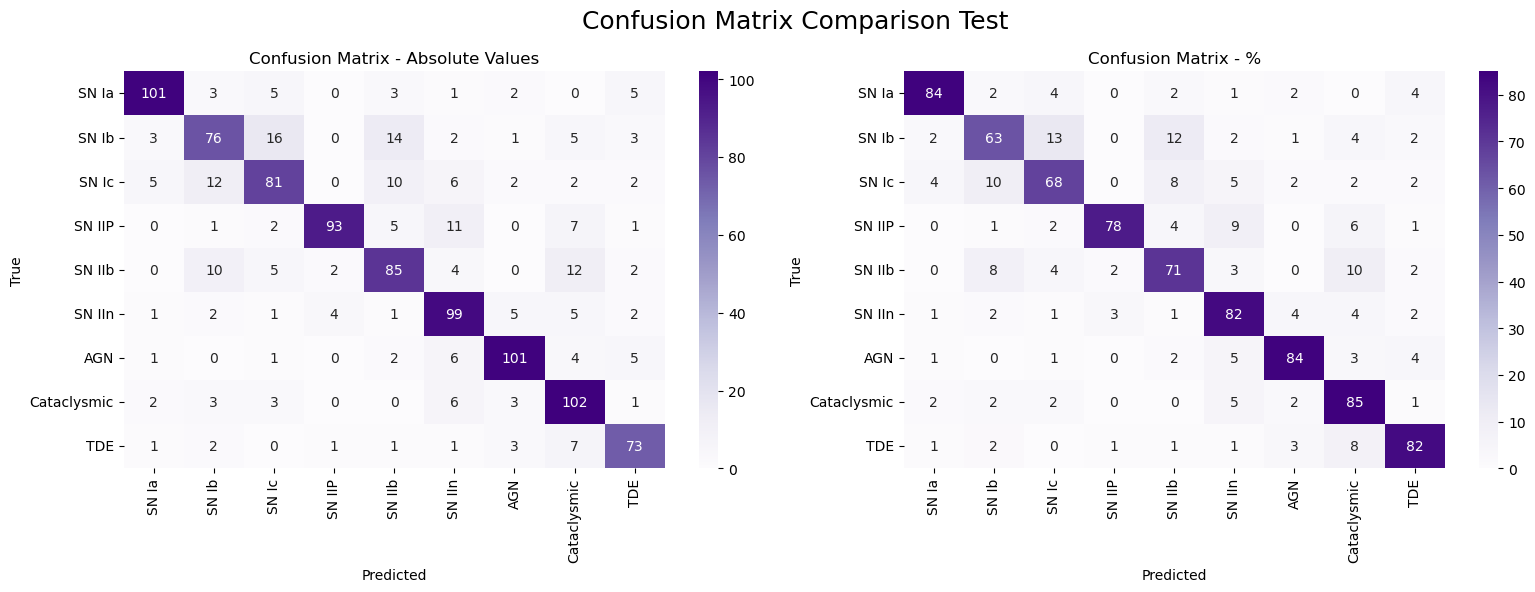

>>> Test Loss: 0.7583, Acc: 77.31%, F1: 0.7741


In [45]:


def build_model(config):
    class BaseLineSpectraCNN(nn.Module):
        def __init__(self, input_channels=1, input_length=4096, num_classes=9):
            super().__init__()

            self.conv_block = nn.Sequential(
                nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv1d(32, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2)  # → [B, 64, 2048]
            )

            reduced_length = input_length // 2  # after pooling
            self.flatten_dim = 64 * reduced_length

            self.mlp = nn.Sequential(
                nn.Linear(self.flatten_dim, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, len(config['class_order']))
            )

        def forward(self, x):
            x = self.conv_block(x)
            x = x.view(x.size(0), -1)
            return self.mlp(x)

    return BaseLineSpectraCNN(
        input_channels=1,
        input_length=4096,
        num_classes=len(config['class_order'])
    )


    
test_score, test_metrics = main(config=final_config, build_model_fn=build_model)




##  Exercise: GalSpecNet Architecture

---

###  Input

- **Spectral Input:** `[B, 1, 4096]`

---

###  Convolution + Pooling Layers

1. **Method:** `Conv1D + ReLU`  
   → **Output:** `[B, 64, 4096]`

2. **Method:** `MaxPool1D`  
   → **Output:** `[B, 64, 1024]`

3. **Method:** `Conv1D + ReLU`  
   → **Output:** `[B, 128, 1024]`

4. **Method:** `MaxPool1D`  
   → **Output:** `[B, 128, 256]`

5. **Method:** `Conv1D + ReLU`  
   → **Output:** `[B, 256, 256]`

6. **Method:** `MaxPool1D`  
   → **Output:** `[B, 256, 64]`

7. **Method:** `Conv1D + ReLU`  
   → **Output:** `[B, 32, 64]`

---

###  Flatten

- `[B, 32, 64]` → `[B, 2048]`

---

###  Classifier (MLP)

8. **Method:** `Dropout(0.3)`  
   → **Output:** `[B, 2048]`

9. **Method:** `Linear + ReLU`  
   → **Output:** `[B, 64]`

10. **Method:** `Linear + ReLU`  
    → **Output:** `[B, 32]`

11. **Method:** `Linear`  
    → **Output:** `[B, 9]`

---

###  Output

- **Method:** `Softmax`  
  → **Output:** Class probabilities `[B, 9]`


In [23]:
### Instructions:
# Replace each ___ below with appropriate values according to the structure.
# Do NOT change the layer order or add/remove layers.

def build_model(config):
    class GalSpecNet(nn.Module):
        def __init__(self, input_channels=1, input_length=4096, num_classes=9):
            super().__init__()

            #  Feature Extractor
            self.feature_extractor = nn.Sequential(
                # TODO 1: Fill in first Conv1D layer to output [B, 64, 4096]
                nn.Conv1d(input_channels, ___, kernel_size=___, stride= 1, padding=___),  
                nn.ReLU(),
                # TODO 2: Add MaxPool1d to downsample to [B, 64, 1024]
                nn.MaxPool1d(kernel_size=___,stride=___),

                # TODO 3: Second Conv1D to go from 64 → 128 channels
                nn.Conv1d(___, ___, kernel_size=___,stride=1, padding=___),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=___, stride=__),  # [B, 128, 256]

                # TODO 4: Third Conv1D to go from 128 → 256 channels
                nn.Conv1d(___, ___, kernel_size=___,stride=1, padding=___),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=___,stride=__),  # [B, 256, 64]

                # TODO 5: Final Conv1D to go from 256 → 32 channels, output [B, 32, 64]
                nn.Conv1d(___, ___, kernel_size=___,stride=1, padding=___),
                nn.ReLU()
            )

            #  Flatten
            # TODO 6: What should the flatten size be?
            self.flatten_dim = ___ * ___  # = 2048

            #  MLP Classifier
            self.classifier = nn.Sequential(
                # TODO 7: Add Dropout layer with correct probability
                nn.Dropout(p=___),  # [B, 2048]
                # TODO 8: Fully connected layers
                nn.Linear(___, ___),
                nn.ReLU(),
                nn.Linear(___, ___),
                nn.ReLU(),
                nn.Linear(___, len(config['class_order']))  # [B, 9]
            )

        def forward(self, x):
            x = self.feature_extractor(x)
            x = x.view(x.size(0), -1)  # flatten to [B, 2048]
            return self.classifier(x)

    return GalSpecNet(
        input_channels=1,
        input_length=4096,
        num_classes=len(config['class_order'])
    )




In [24]:

config = {
        "class_order": list(range(9))  # mock 9 classes
    }
model = build_model(config)
x = torch.randn(2, 1, 4096)  # random input: batch_size=2
y = model(x)

print(" Output shape:", y.shape)  # should be [2, 9]

### ONNX Inference and Evaluation on Spectral Test Data

In [9]:
import torch
import onnxruntime as ort
import numpy as np

# Path to the ONNX model and test data
onnx_path = "Data/model/3850-8500.onnx"
pt_path = "Data/test.pt"

# Load the test data
data = torch.load(pt_path)
x = data['flux']
y_true = data['labels']
x_np = x.numpy().astype(np.float32)

if x_np.ndim == 2:
    x_np = np.expand_dims(x_np, axis=1)  # Ensure shape is [N, 1, 4096]

# Load the ONNX model
session = ort.InferenceSession(onnx_path)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Run inference
outputs = session.run([output_name], {input_name: x_np})  # [N, num_classes]
predictions = np.argmax(outputs[0], axis=1)               # [N]

# Convert string labels to index and compare predictions
class_order = ['SN Ia', 'SN Ib', 'SN Ic', 'SN IIP', 'SN IIb', 'SN IIn', 'AGN', 'Cataclysmic', 'TDE', 'SLSN-I']
y_true_np = np.array([class_order.index(label) for label in y_true])
y_pred_names = [class_order[i] for i in predictions[:30]]
y_true_names = [class_order[i] for i in y_true_np[:30]]

# Print comparison results
print("\n🧾 Prediction vs Ground Truth:")
for i, (pred, true) in enumerate(zip(y_pred_names, y_true_names)):
    print(f"Sample {i:02d} | Predicted: {pred:<12} | True: {true}")
